# ResNet50 Transfer Learning Model with Bilinear Attachment

In [8]:
import os
import re
import ast
import json
import pkbar
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from torch.utils.data.distributed import DistributedSampler
import torchvision
from torchvision import transforms, utils
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
from pathlib import Path
import matplotlib.pyplot as plt

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT = Path('../asun/Smart-Trash/data/isbnet/')

## Data Pre-processing
For the baseline model, we will not be applying any data augmentation or color manipulation.
- Get the index CSV file that includes all files their respective directory and labels.

### Trash Dataset
Dataset object to handle various sets of data that we will be dealing with including: TrashNet, ISBNet, and ISBNet extended.

In [10]:
def split(length, split, shuffle=True):
    """
    :returns: random samplers for both the training dataset and the validation dataset.
    """
    indicies = list(range(length))
    split = int(np.floor(split * length))
    
    if shuffle:
        np.random.shuffle(indicies)
    
    train_indicies, val_indicies = indicies[split:], indicies[:split]
    train_sampler = data.SubsetRandomSampler(train_indicies)
    val_sampler = data.SubsetRandomSampler(val_indicies)
    
    return train_sampler, val_sampler

A split function is defined to split the dataset after it is defined as a `DataSet` object. This makes it really easy to handle, because after splitting it, we are creating a sampler object. There is no need to modify the dataset object itself.

In [11]:
class TrashDataset(Dataset):
    def __init__(self, metadata: pd.DataFrame, directory: Path, land_dict: dict, noland=0., transform=None):
        """
        metadata: DataFrame that contains information about each image and their labels.
        directory: the directory where the trash data is kept
        root_dir: path to the `directory`
        transform: optional augmentations that are to be applied onto the images
        """
        self.images_folder = directory
        self.meta = metadata
        self.transform = transform
        self.label_dict = {
            'cans': 0,
            'landfill': 1,
            'paper': 2,
            'plastic': 3,
            'tetrapak': 4
        }
        self.noland = noland
        self.land_dict = land_dict
  
    def __len__(self) -> int:
        return len(self.meta)
  
    def __getitem__(self, idx) -> dict:
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Image preprocessing
        image = Image.open(self.meta.iloc[idx, 0])
        
        # Labels preprocessing
        labels = [0] * 5
        labels[self.label_dict[self.meta.iloc[idx, 1]]] = 1
        
        # Metadata preprocessing
        trashcan_time = self._label_smoothing(np.array(self.meta.iloc[idx, 4]), 0.2)
        landmarks = self._encode(self.meta.iloc[idx, 6], self.land_dict, padding=self.noland)
        trashcan_location = self.meta.iloc[idx, 5]
        distances = [self._pythag(v) for v in trashcan_location]
        for index, item in enumerate(self.meta.iloc[idx, 6]):
            landmarks[self.land_dict[item]] = distances[index]
        
        
        sample = {'image': image,
                  'meta': torch.tensor(np.concatenate((trashcan_time,
                                                      landmarks), axis=0), dtype=torch.float),
                  'path': self.meta.iloc[idx, 0],
                  'label': torch.tensor(self.label_dict[self.meta.iloc[idx, 1]], dtype=torch.float)}

        if self.transform:
              sample['image'] = self.transform(sample['image'])
        return sample
    
    def _encode(self, need_encoding: list, reference: dict, padding=0.) -> np.array:
        one_hot = np.zeros(len(reference))
        for item in need_encoding:
            one_hot[reference[item]] = 1.
        one_hot = one_hot / self._pythag(one_hot)
        one_hot = np.where(one_hot==0, padding, one_hot)
        return -np.log(one_hot)
    
    def _label_smoothing(self, labels: np.array, smoothing: float) -> np.array:
        return np.where(labels==1, 1-smoothing, 0+smoothing)
    
    def _pythag(self, coor):
        return np.linalg.norm(coor, ord=2)

Because we are using cross entropy loss we can express the loss as simply a scalar. This scalar is between [0-numclasses]. 

# Model and Training Setup
- ResNet50 pretrained with ImageNet
- FC layers as classifiers. I did not use log-softmax activation or a normalization on the last layer because predictions are based on max value. A normalizing activation function on the last layer would diminish the network's ability to learn.
- CrossEntropy loss and Adam optimizer.

### Model Definition

In [89]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.head = models.resnet50(pretrained=True)
        # Remove classification layers so that we are able to add our own CNN layers
        self.head.requires_grad = False
        self.head.fc = nn.Sequential(
                                nn.Linear(2048, 1024, bias=True),
                                nn.BatchNorm1d(1024),
                                nn.ReLU(),
                                nn.Dropout(0.25))
        self.fc1 = nn.Sequential(
                                nn.Linear(1024, 512, bias=True),
                                nn.BatchNorm1d(512),
                                nn.ReLU(),
                                nn.Dropout(0.50),
                                nn.Linear(512, 5, bias=True),
                                nn.ReLU()
        )
        self.meta_fc1 = nn.Linear(21, 16, bias=True)
        self.meta_relu1 = nn.ReLU()
        self.bilinear = nn.Bilinear(16, 1024, 1024)
        
    def forward(self, image, metadata):
        metadata = self.meta_fc1(metadata)
        metadata = self.meta_relu1(metadata)
        image = self.head(image)
        combined = self.bilinear(metadata, image)
        combined = self.meta_relu1(combined)
        return self.fc1(combined)
  
    def num_flat_features(self, x):
        """
        https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
        """
        size = x.size()[1:]  # get all dimensions except for batch size
        features = 1
        for s in size:
            features *= s
        return features

### Define Constants

In [14]:
FOLDS = 5
EPOCHS = 50
BATCH_SIZE = 32
SAVE_DIR = 'kfold-resnet-meta-bilinear2'

### KFold Training and CV
* KFold setup with `StratifiedKFold`
* Creating Dataloaders in training loop.
* Using Adam and CrossEntropy Loss
* Center crop on images to make them 224x224 so ResNet will be able to take them.

In [6]:
train_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomAffine(15),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
])

In [13]:
metadata = pd.read_csv(ROOT / 'metadata.csv')
land_dict = json.load(open(ROOT / 'metalabels.json'))['landmarks']
metadata['categorial_time'] = metadata['categorial_time'].apply(ast.literal_eval)
metadata['trashcan_time'] = metadata['trashcan_time'].apply(ast.literal_eval)
metadata['trashcan_location'] = metadata['trashcan_location'].apply(ast.literal_eval)
metadata['landmarks'] = metadata['landmarks'].apply(ast.literal_eval)
TRAIN_VAL = TrashDataset(metadata, ROOT, land_dict=land_dict, noland=1e3, transform=transform)

### Loss Function and Optimizer

### Training and Validation

In [9]:
trash_labels = metadata.iloc[:,1].values
s = StratifiedKFold(n_splits=FOLDS, shuffle=True).split(metadata, trash_labels)

In [ ]:
for fold, (train_idx, test_idx) in enumerate(s):
    max_f1 = 0
    
    model = ResNet()
    model.to(0)
    
    celoss = nn.CrossEntropyLoss(weight=torch.tensor([6.0241, 3.6496, 2.4390, 1.0823, 4.3860]).to(0, dtype=torch.float))
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4,
                       weight_decay=1e-9)
    
    train = TrashDataset(metadata.iloc[train_idx,:], ROOT, land_dict, noland=1e3, transform=train_transform)
    test = TrashDataset(metadata.iloc[test_idx,:], ROOT, land_dict, noland=1e3, transform=val_transform)
    
    train_loader = torch.utils.data.DataLoader(train, 
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=4) 
    valid_loader = torch.utils.data.DataLoader(test, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4)
    
    for epoch in range(EPOCHS):
        print(f'Fold: {fold+1} \t Epoch {epoch+1}/{EPOCHS} \t Max F1: {round(max_f1,4)}')
        pbar = pkbar.Kbar(target=len(train_loader), width=15)
        # Training 
        model.train()
        for batch_num, inputs in enumerate(train_loader):
            images = inputs['image'].to(0, dtype=torch.float)
            _meta = inputs['meta'].to(0, dtype=torch.float)
            labels = inputs['label'].to(0, dtype=torch.long)

            # Forward Feeding
            optimizer.zero_grad()
            outputs = model(images, _meta)
            loss_value = celoss(outputs, labels)
            loss_value.backward()
            optimizer.step()

            # Generate Metrics and Update Progress Bar Every 10~20 Batches
            predictions = torch.max(outputs, 1)[1].cpu().detach().numpy()
            metric_label = labels.cpu().detach().numpy()
            f1 = f1_score(metric_label, predictions, average='macro')
            accuracy = accuracy_score(metric_label, predictions)

            # Update Progress Bar
            pbar.update(batch_num, values=[('CELoss', loss_value.item()), ('F1_Score', f1),
                                           ('Accuracy', accuracy)])

            # Free up CUDA memory
            del labels
            torch.cuda.empty_cache()

        val_loss, val_f1, val_acc = [], [], []
        model.eval()
        for inputs in valid_loader:
            images = inputs['image'].to(0, dtype=torch.float)
            labels = inputs['label'].to(0, dtype=torch.long)
            _meta = inputs['meta'].to(0, dtype=torch.float)

            # Forward Feeding
            outputs = model(images, _meta)
            predictions = torch.max(outputs, 1)[1].cpu().detach().numpy()
            metric_label = labels.cpu().detach().numpy()

            # Metric Calculation
            val_loss.append(celoss(outputs, labels).item())
            val_f1.append(f1_score(metric_label, predictions, average='macro'))
            val_acc.append(accuracy_score(metric_label, predictions))

        pbar.add(1, values=[('val_CELoss', sum(val_loss)/len(val_loss)),
                            ('val_F1_Score', sum(val_f1)/len(val_f1)),
                            ('val_Accuracy', sum(val_acc)/len(val_acc))])
        if sum(val_f1)/len(val_f1) > max_f1:
            max_f1 = sum(val_f1)/len(val_f1)
            torch.save(model.state_dict(), f'../asun/Smart-Trash/models/{SAVE_DIR}/model{fold}-{epoch}.pth')

Fold: 1 	 Epoch 1/50 	 Max F1: 0
23/23 [===============] - 187s 8s/step - CELoss: 1.5596 - F1_Score: 0.2234 - Accuracy: 0.2656 - val_CELoss: 1.5017 - val_F1_Score: 0.3355 - val_Accuracy: 0.3409
Fold: 1 	 Epoch 2/50 	 Max F1: 0.3355
22/23 [=============>.] - ETA: 6s - CELoss: 1.2508 - F1_Score: 0.4407 - Accuracy: 0.5033 

# Inference and Model EDA
- Load weights from model with best validation loss score.
- Predict on all samples in "pure" isbnet
- Generate a confusion matrix of these samples and display false positives / negatives.

In [108]:
# ptrn = re.compile(r'model([0-9]+).pth')
# model_epochs = [int(ptrn.search(v).group(1)) for v in os.listdir(f'../asun/Smart-Trash/models/{SAVE_DIR}/')]
best_model = f'model1-10.pth'

In [90]:
inference = ResNet()
inference = inference.to(device)

In [109]:
inference.load_state_dict(torch.load(f'../asun/Smart-Trash/models/{SAVE_DIR}/{best_model}'))

<All keys matched successfully>

In [104]:
inference.eval()
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
])
testset = TrashDataset(metadata, ROOT, land_dict=land_dict, noland=1e3, transform=transform)
testset_loader = DataLoader(testset, batch_size=16, num_workers=4)

In [110]:
filenames = np.array([])
labels = np.array([])
predictions = np.array([])

for index, sample in enumerate(testset_loader):
    image = sample['image'].to(0)
    meta = sample['meta'].to(0)
    labels = np.append(labels, sample['label'])
    filenames = np.append(filenames, sample['path'])
    predict = torch.max(inference(image, meta), 1)[1].cpu().cpu().detach().numpy()
    predictions = np.append(predictions, predict)

## Confusion Matrix

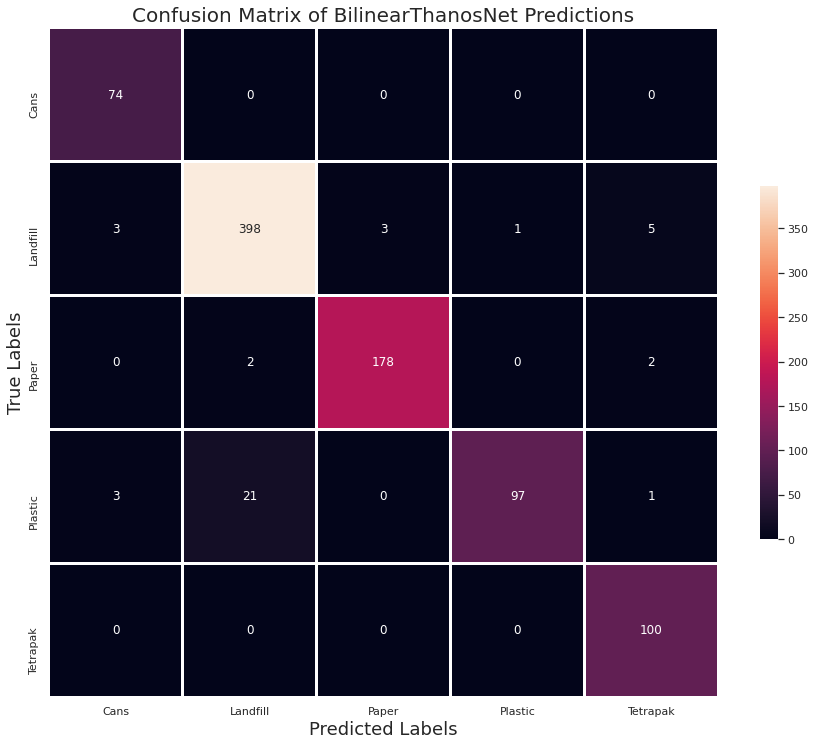

In [111]:
sns.set()

c_matrix = confusion_matrix(labels, predictions)
f, ax = plt.subplots(figsize=(15, 13))

# Cell Labels
cell_labels = c_matrix.flatten()

# Categories
categories = ['Cans', 'Landfill', 'Paper', 'Plastic', 'Tetrapak']

# Color Scheme
cmap = sns.diverging_palette(160, 250, s=100, l=70, n=10, as_cmap=True)

#  Metrics
f1 = f1_score(labels, predictions, average='macro')
accuracy = accuracy_score(labels, predictions)

plt.title('Confusion Matrix of BilinearThanosNet Predictions', fontsize=20)
sns.heatmap(c_matrix, fmt='', annot=c_matrix, cbar_kws={"shrink": .5},
            xticklabels=categories, yticklabels=categories, linewidth=1.5, square=True)
# plt.xlabel('Predictions Labels\nAccuracy: {:4f}, F1 Score: {:4f}'.format(accuracy, f1), fontsize=18)
plt.ylabel('True Labels', fontsize=18)
plt.xlabel('Predicted Labels', fontsize=18)
f.savefig('../asun/Smart-Trash/results/bilinear-resnet-confmatrix2.png', ppi=300)

In [113]:
print(accuracy)

0.9538288288288288


## Sample Analysis
In this section, we examine the individual samples where the model predicted correctly and incorrectly. We first define a helper function to handle displaying images in groups of grids.

**Helper functions and helper map defined below.**
- `labels_dict` --> Map that maps indicices to their respective labels.
- `imshow` --> Displays a list of images
- `get_images` --> Gets encoded image arrays from dataloader.

In [35]:
labels_dict = {
    0: 'Can',
    1: 'Landfill', 
    2: 'Paper',
    3: 'Plastic',
    4: 'Tetrapak'
}

In [36]:
def imshow(inp, title=None, xlabel=None):
    """
    Displays a tensor of tensor images.
    """
    f, ax = plt.subplots(figsize=(20, 15))
    ax.grid(False)
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize='20')
    if xlabel is not None:
        plt.xlabel('Predictions: ' + str(xlabel), fontsize='18')
    plt.pause(0.001)

In [37]:
def get_images(loader, idxs, num):
    """
    Gets images from the `dataset` object by indexing them using the `num` parameters.
    """
    if len(idxs) < num:
        if len(idxs) == 0:
            return
        return torch.tensor([loader[i]['image'].numpy() for i in idxs], dtype=torch.float)
    else:
        images = []
        count = 0
        for idx in idxs:
            images.append(loader[idx]['image'].numpy())
            if count + 1 == num:
                return torch.tensor(images, dtype=torch.float)
            count += 1

In [38]:
def generate_images(labels_dict, labels, predictions, category, loader, correct=True, nums=4):
    c_labels = np.where(labels==category)
    c_predictions = np.where(predictions==category)
    
    # Get sample indicies
    if correct:
        idxs = np.intersect1d(c_labels, c_predictions)
    else:
        idxs = np.setdiff1d(c_labels, c_predictions)
    
    images = get_images(loader, idxs, nums)
    grid = torchvision.utils.make_grid(images)
    if len(idxs) < nums:
        x_label = [labels_dict[int(predictions[i])] for i in idxs[0:len(idxs)]]
    else:
        x_label = [labels_dict[int(predictions[i])] for i in idxs[0:nums]]
    
    s = 'Correctly' if correct else 'Incorrectly'
    imshow(grid, title=f'{s} Predicted Pictures ({labels_dict[category]} Class)', xlabel=x_label)

## Cans Analysis

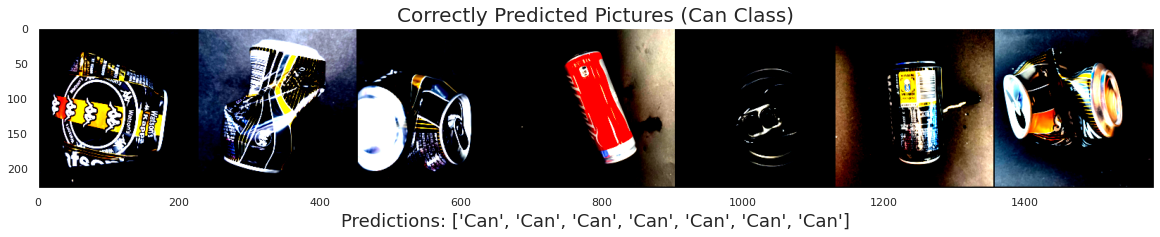

In [44]:
generate_images(labels_dict, labels, predictions, 0, testset, nums=7)

These are pictures of cans that were correctly predicted by the classifier. The `RandomResizedCrop` randomly changes the scale, this causes the large variation in validation scores across epochs. When the validation score is really high that means it has discovered a crop that is really beneficial.

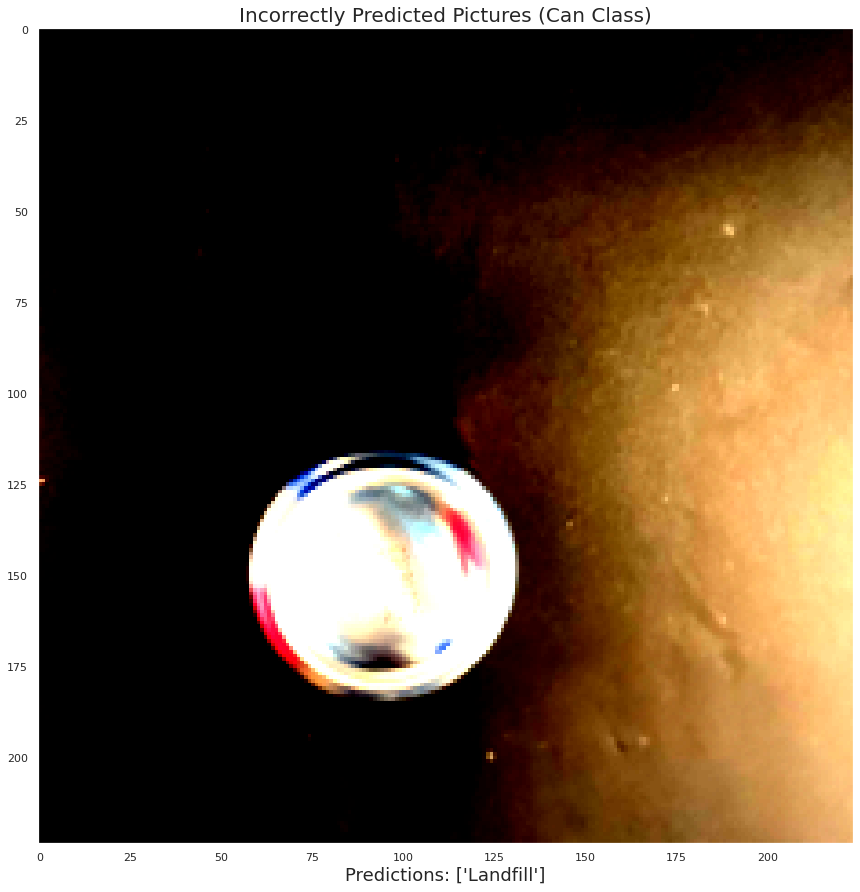

In [46]:
generate_images(labels_dict, labels, predictions, 0, correct=False, loader=testset, nums=7)

## Landfill Analysis

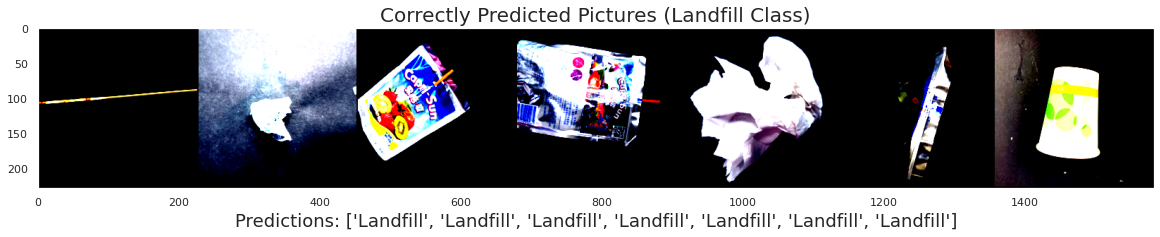

In [47]:
generate_images(labels_dict, labels, predictions, 1, correct=True, loader=testset, nums=7)

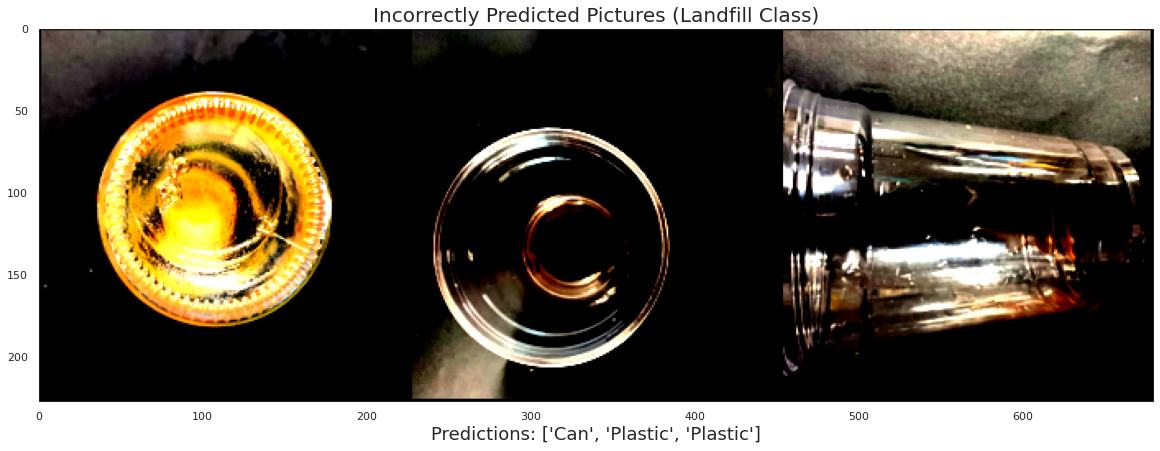

In [48]:
generate_images(labels_dict, labels, predictions, 1, correct=False, loader=testset, nums=7)

## Paper Analysis

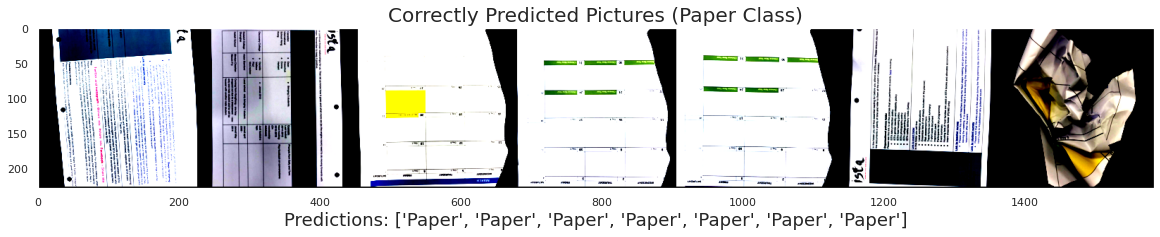

In [49]:
generate_images(labels_dict, labels, predictions, 2, correct=True, loader=testset, nums=7)

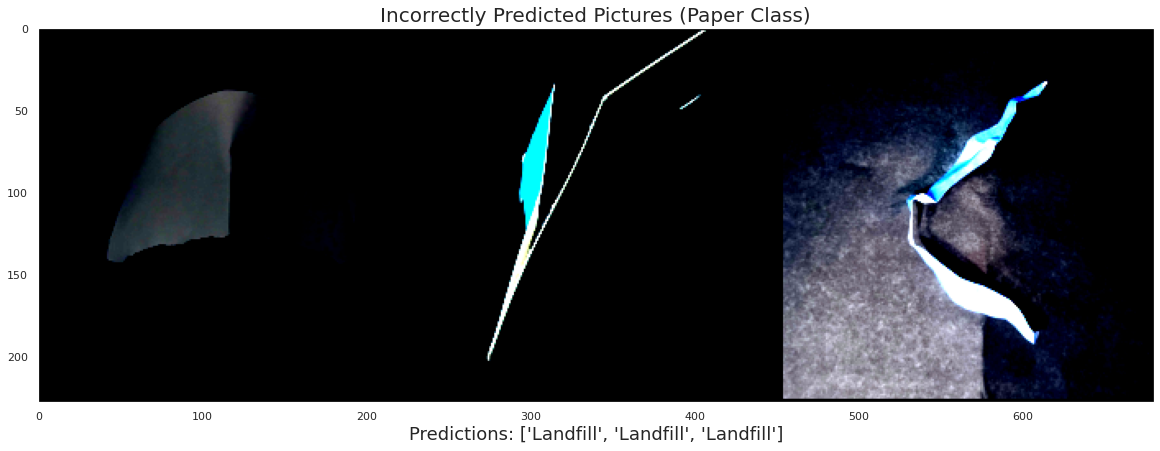

In [50]:
generate_images(labels_dict, labels, predictions, 2, correct=False, loader=testset, nums=7)

## Plastics Class

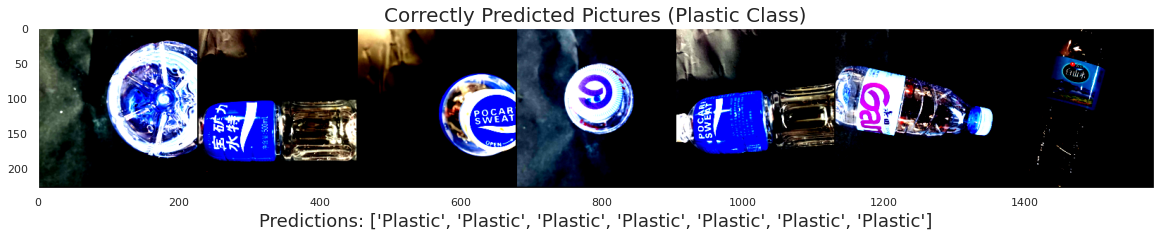

In [51]:
generate_images(labels_dict, labels, predictions, 3, correct=True, loader=testset, nums=7)

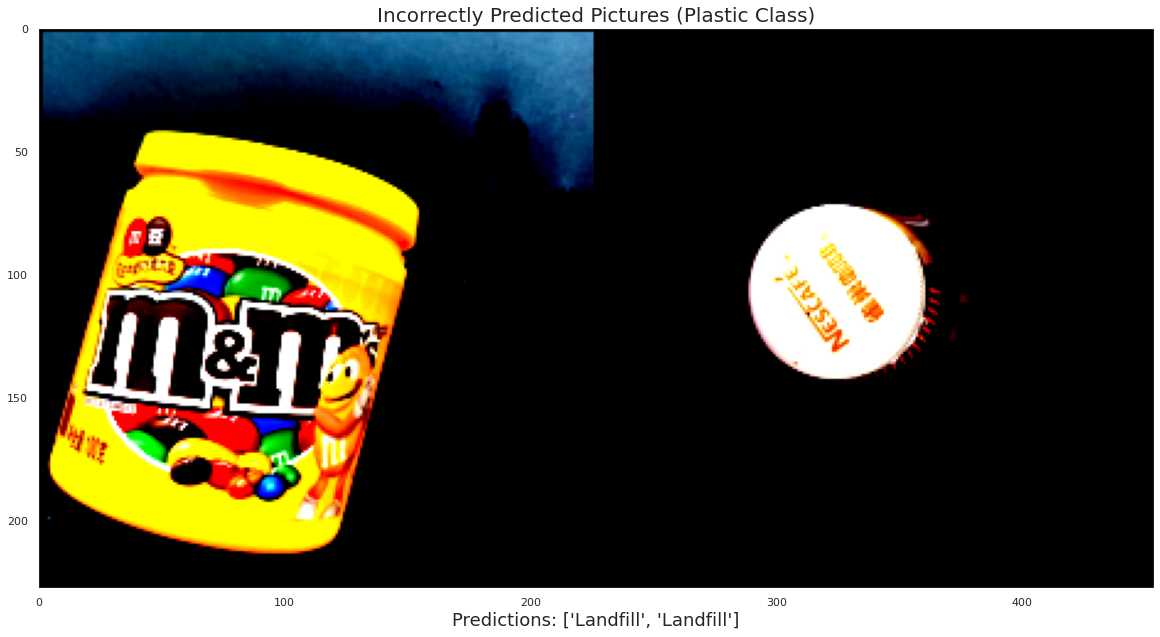

In [52]:
generate_images(labels_dict, labels, predictions, 3, correct=False, loader=testset, nums=7)

## Tetrapak Class

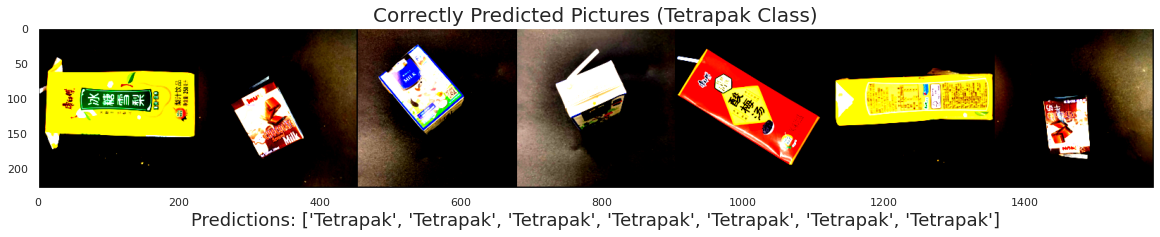

In [53]:
generate_images(labels_dict, labels, predictions, 4, correct=True, loader=testset, nums=7)

In [54]:
generate_images(labels_dict, labels, predictions, 4, correct=False, loader=testset, nums=7)

TypeError: tensor or list of tensors expected, got <class 'NoneType'>